In [1]:
# Header files
import numpy as np
np.random.seed(123)
import gzip
import _pickle as cPickle
import os
from collections import Counter
import sys
from PIL import Image

from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.neighbors import KDTree

import keras
from keras.preprocessing import image
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Using TensorFlow backend.


# Data Loading

In [2]:
# Data Loading Path
word2vec_path    = "data/class_vectors.npy" # word2vec model of seen and unseen class
data_path        = "data/zeroshot_data.pkl" # Feature of segmented images
model_path       = "model/"

In [3]:
# Loading Classes
global train_class
global zsl_class

with open('train_classes.txt', 'r') as infile:
    train_class = [str.strip(line) for line in infile]

with open('zsl_classes.txt', 'r') as infile:
    zsl_class = [str.strip(line) for line in infile]

In [4]:
train_class

['arm',
 'boy',
 'bread',
 'chicken',
 'child',
 'computer',
 'ear',
 'house',
 'leg',
 'sandwich',
 'television',
 'truck',
 'vehicle',
 'watch',
 'woman']

In [5]:
zsl_class

['car', 'food', 'hand', 'man', 'neck']

In [6]:
# Data Loading
with gzip.GzipFile(data_path, 'rb') as file:
    data = cPickle.load(file)

In [7]:
data # Data (label, image features)

[('arm', array([[2.3391004, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0.       , 1.3593935, 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('arm', array([[6.9050093, 1.942784 , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0.       , 0.       , 0.       , ..., 0.       , 0.6234552,
          1.051313 ]], dtype=float32)),
 ('arm', array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          0.0272571]], dtype=float32)),
 ('arm', array([[0.9722133, 6.7332063, 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('arm', array([[0.       , 4.0391464, 0.       , ..., 0.       , 1.9906807,
          0.       ]], dtype=float32)),
 ('arm', array([[2.8369222, 1.7559707, 0.       , .

In [8]:
label_encoder   = LabelEncoder()
label_encoder.fit(train_class)

LabelEncoder()

In [9]:
training_data = [i for i in data if i[0] in train_class]
zero_shot_data = [i for i in data if i[0] not in train_class]

In [10]:
training_data

[('arm', array([[2.3391004, 0.       , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0.       , 1.3593935, 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('arm', array([[6.9050093, 1.942784 , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0.       , 0.       , 0.       , ..., 0.       , 0.6234552,
          1.051313 ]], dtype=float32)),
 ('arm', array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          0.0272571]], dtype=float32)),
 ('arm', array([[0.9722133, 6.7332063, 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('arm', array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('arm', array([[0.       , 4.0391464, 0.       , ..., 0.       , 1.9906807,
          0.       ]], dtype=float32)),
 ('arm', array([[2.8369222, 1.7559707, 0.       , .

In [11]:
zero_shot_data

[('car',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.19247377,
          2.0497704 ]], dtype=float32)),
 ('car', array([[ 0.      , 13.588848,  0.      , ...,  0.      ,  0.      ,
           0.      ]], dtype=float32)),
 ('car',
  array([[4.47886   , 0.        , 0.        , ..., 0.        , 0.        ,
          0.57687116]], dtype=float32)),
 ('car', array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('car', array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)),
 ('car', array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
          1.3444611]], dtype=float32)),
 ('car', array([[1.0324109, 1.1438572, 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32)),
 ('car', array([[0.       , 0.       , 0.       , ..., 0.       , 1.9662347,
          0.       ]], dtype=float32)),
 ('car',
  array([[ 0.       ,  0.       ,  0.       , ...,  3.6768425,  0.       ,
          10.536699 ]], dtype=float32)),
 ('car', array([[0., 0., 0.

In [12]:
np.random.shuffle(training_data)

In [13]:
train_data = [(i[1], to_categorical(label_encoder.transform([i[0]]), num_classes=15))for i in training_data]

In [14]:
train_data # train data with encoded label

[(array([[0.        , 0.        , 0.        , ..., 0.32161403, 2.1122184 ,
          0.        ]], dtype=float32),
  array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        dtype=float32)),
 (array([[7.7244616, 7.44922  , 0.       , ..., 0.       , 0.       ,
          0.       ]], dtype=float32),
  array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        dtype=float32)),
 (array([[ 0.       ,  0.       ,  0.       , ...,  2.4025886,  0.       ,
          22.621761 ]], dtype=float32),
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],
        dtype=float32)),
 (array([[ 4.381696 , 17.835289 ,  0.       , ...,  0.       ,  4.2973228,
           0.       ]], dtype=float32),
  array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],
        dtype=float32)),
 (array([[4.889214, 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
        dtype=float32),
  array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [15]:
X_train, Y_train    = zip(*train_data)

In [16]:
X_train = np.squeeze(np.asarray(X_train))

In [17]:
Y_train =  np.squeeze(np.asarray(Y_train))

In [18]:
X_train = normalize(X_train, norm='l2')

In [19]:
X_train.shape # size of training data

(5993, 4096)

In [20]:
Y_train.shape # size of training labels

(5993, 15)

In [21]:
X_train

array([[0.        , 0.        , 0.        , ..., 0.00241382, 0.01585288,
        0.        ],
       [0.02962681, 0.02857114, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00761529, 0.        ,
        0.07170235],
       ...,
       [0.0019602 , 0.04611515, 0.        , ..., 0.033859  , 0.        ,
        0.        ],
       [0.02178524, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01137056, 0.        , ..., 0.        , 0.        ,
        0.0004534 ]], dtype=float32)

In [22]:
Y_train

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [23]:
Y_zsl, X_zsl = zip(*zero_shot_data)

In [24]:
X_zsl = np.squeeze(np.asarray(X_zsl))

In [25]:
Y_zsl = np.squeeze(np.asarray(Y_zsl))

In [26]:
X_zsl = normalize(X_zsl, norm='l2')

In [27]:
X_zsl.shape # Zero shot data

(1999, 4096)

In [28]:
Y_zsl.shape # Zero shot labels

(1999,)

# Model Building

In [29]:
global classes, attributes, epoch, batch_size
classes = 15
attributes = 300
batch_size = 32
epoch = 40

In [30]:
def custom_kernel_init(shape):
    class_vectors       = np.load(word2vec_path)
    train_vectors    = sorted([(label, vec) for (label, vec) in class_vectors if label in train_class], key=lambda x: x[0])
    class_names, vectors = zip(*train_vectors)
    vectors             = np.asarray(vectors, dtype=np.float)
    vectors             = vectors.T
    return vectors

In [31]:
model = Sequential()
model.add(Dense(1024, input_shape=(4096,), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.8))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(attributes, activation='relu'))
model.add(Dense(classes, activation='softmax', trainable=False, kernel_initializer=custom_kernel_init))

In [32]:
adam = Adam(lr=5e-5)

In [33]:
model.compile(loss      = 'categorical_crossentropy',
                  optimizer = adam,
                  metrics   = ['categorical_accuracy', 'top_k_categorical_accuracy'])

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
__________

# Model Training

In [35]:
earlystop = EarlyStopping(monitor='val_top_k_categorical_accuracy', min_delta=0.0001, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]

In [36]:
history = model.fit(X_train, Y_train,
                        validation_split = 0.2,
                        verbose         = 1,
                        epochs          = epoch,
                        batch_size      = batch_size,
                        shuffle         = True)
'''
history = model.fit(X_train, Y_train,
                        validation_split = 0.2,
                        verbose         = 1,
                        epochs          = epoch,
                        callbacks=callbacks_list,
                        batch_size      = batch_size,
                        shuffle         = True)
'''

Train on 4794 samples, validate on 1199 samples
Epoch 1/40
4794/4794 [==============================] - 27s 6ms/step - loss: 3.1238 - categorical_accuracy: 0.0786 - top_k_categorical_accuracy: 0.3790 - val_loss: 2.4655 - val_categorical_accuracy: 0.2494 - val_top_k_categorical_accuracy: 0.7064
Epoch 2/40
4794/4794 [==============================] - 23s 5ms/step - loss: 2.7794 - categorical_accuracy: 0.1128 - top_k_categorical_accuracy: 0.4585 - val_loss: 2.3054 - val_categorical_accuracy: 0.3228 - val_top_k_categorical_accuracy: 0.7982
Epoch 3/40
4794/4794 [==============================] - 23s 5ms/step - loss: 2.5779 - categorical_accuracy: 0.1556 - top_k_categorical_accuracy: 0.5438 - val_loss: 2.1421 - val_categorical_accuracy: 0.3445 - val_top_k_categorical_accuracy: 0.8274
Epoch 4/40
4794/4794 [==============================] - 22s 5ms/step - loss: 2.4150 - categorical_accuracy: 0.2057 - top_k_categorical_accuracy: 0.6081 - val_loss: 1.9807 - val_categorical_accuracy: 0.3795 - val

Epoch 34/40
4794/4794 [==============================] - 22s 5ms/step - loss: 1.2207 - categorical_accuracy: 0.5232 - top_k_categorical_accuracy: 0.9441 - val_loss: 1.1625 - val_categorical_accuracy: 0.5496 - val_top_k_categorical_accuracy: 0.9450
Epoch 35/40
4794/4794 [==============================] - 23s 5ms/step - loss: 1.2267 - categorical_accuracy: 0.5330 - top_k_categorical_accuracy: 0.9389 - val_loss: 1.1537 - val_categorical_accuracy: 0.5588 - val_top_k_categorical_accuracy: 0.9441
Epoch 36/40
4794/4794 [==============================] - 23s 5ms/step - loss: 1.1971 - categorical_accuracy: 0.5313 - top_k_categorical_accuracy: 0.9424 - val_loss: 1.1546 - val_categorical_accuracy: 0.5505 - val_top_k_categorical_accuracy: 0.9466
Epoch 37/40
4794/4794 [==============================] - 22s 5ms/step - loss: 1.1922 - categorical_accuracy: 0.5338 - top_k_categorical_accuracy: 0.9443 - val_loss: 1.1501 - val_categorical_accuracy: 0.5605 - val_top_k_categorical_accuracy: 0.9466
Epoch 38

'\nhistory = model.fit(X_train, Y_train,\n                        validation_split = 0.2,\n                        verbose         = 1,\n                        epochs          = epoch,\n                        callbacks=callbacks_list,\n                        batch_size      = batch_size,\n                        shuffle         = True)\n'

In [37]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'val_top_k_categorical_accuracy', 'loss', 'categorical_accuracy', 'top_k_categorical_accuracy'])


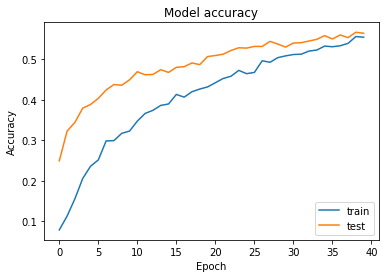

In [154]:
# summarize history for categorical_accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

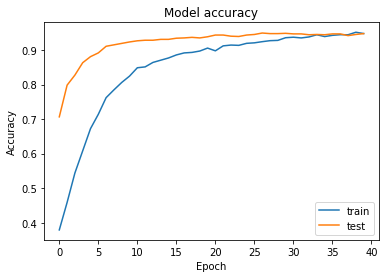

In [155]:
# summarize history for accuracy
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

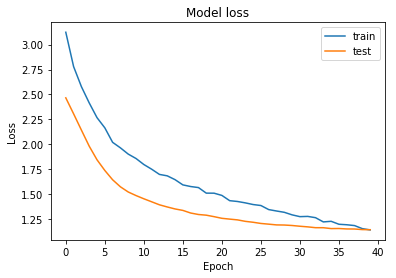

In [156]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Zero shot Model

In [41]:
input_zsl         = model.input
output_zsl         = model.layers[-2].output
zsl_model   = Model(input_zsl, output_zsl)
print(zsl_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1_input (InputLayer)   (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
__________

In [42]:
if not os.path.exists(model_path):
    os.makedirs(model_path)

In [43]:
model_json = zsl_model.to_json()
with open(model_path + "model.json", "w") as json_file:
    json_file.write(model_json)

In [44]:
zsl_model.save_weights(model_path + "model.h5")

# Class Vectors

In [45]:
class_vectors       = sorted(np.load(word2vec_path), key=lambda x: x[0])

In [46]:
class_names, vectors = zip(*class_vectors)

In [47]:
class_names          = list(class_names)

In [48]:
vectors             = np.asarray(vectors, dtype=np.float)

In [49]:
pred_zsl    = zsl_model.predict(X_zsl)

In [50]:
pred_zsl

array([[0.        , 0.04900967, 0.13106477, ..., 0.        , 0.        ,
        0.1458947 ],
       [0.48444527, 0.        , 0.        , ..., 0.        , 1.091429  ,
        0.        ],
       [0.        , 0.15863216, 0.        , ..., 0.        , 1.1764032 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.33761948, ..., 0.        , 0.136335  ,
        0.752725  ],
       [0.        , 0.10544541, 0.41023803, ..., 0.        , 0.        ,
        0.58899516],
       [0.        , 0.        , 0.30079573, ..., 0.        , 0.07864317,
        0.8801582 ]], dtype=float32)

In [51]:
tree = KDTree(vectors)

# Evaluation Metrics

In [52]:
top_5, top_3, top_1 = 0, 0, 0
for i, pred in enumerate(pred_zsl):
    pred            = np.expand_dims(pred, axis=0)
    dist_5, index_5 = tree.query(pred, k=5)
    pred_labels     = [class_names[index] for index in index_5[0]]
    true_label      = Y_zsl[i]
    if true_label in pred_labels:
        top_5 += 1
    if true_label in pred_labels[:3]:
        top_3 += 1
    if true_label in pred_labels[0]:
        top_1 += 1

In [53]:
print("ZERO SHOT LEARNING SCORE")
print("---> Top-5 Accuracy: %.2f" % (top_5 / float(len(X_zsl))))
print("---> Top-3 Accuracy: %.2f" % (top_3 / float(len(X_zsl))))
print("---> Top-1 Accuracy: %.2f" % (top_1 / float(len(X_zsl))))

ZERO SHOT LEARNING SCORE
---> Top-5 Accuracy: 0.83
---> Top-3 Accuracy: 0.43
---> Top-1 Accuracy: 0.15


In [71]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

In [114]:
final_5 = []
final_3 = []
final_1 = []
for i, pred in enumerate(pred_zsl):
    pred_5            = np.expand_dims(pred, axis=0)
    dist_5, index_5 = tree.query(pred_5, k=5)
    pred_label     = [class_names[index] for index in index_5[0]]
    true_label      = Y_zsl[i]
    if true_label in pred_label:
        final_5.append(true_label)
    else:
        final_5.append(pred_label[0])
    if true_label in pred_label[:3]:
        final_3.append(true_label)
    else:
        final_3.append(pred_label[0])
    if true_label in pred_label[0]:
        final_1.append(true_label)
    else:
        final_1.append(pred_label[0])

In [133]:
print("Top 1")
print('Accuracy:', accuracy_score(Y_zsl, final_1))
print('F1 score:', f1_score(Y_zsl, final_1, average = 'macro'))
print('Recall:', recall_score(Y_zsl, final_1, average = 'macro'))
print('Precision:', precision_score(Y_zsl, final_1, average = 'macro'))
#print('\n clasification report:\n', classification_report(Y_zsl,final))
#print('\n confussion matrix:\n',confusion_matrix(Y_zsl, final))

Top 1
Accuracy: 0.14757378689344672
F1 score: 0.054790358669792115
Recall: 0.03687531328320802
Precision: 0.1280481423338566


C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [134]:
print("Top 3")
print('Accuracy:', accuracy_score(Y_zsl, final_3))
print('F1 score:', f1_score(Y_zsl, final_3, average = 'macro'))
print('Recall:', recall_score(Y_zsl, final_3, average = 'macro'))
print('Precision:', precision_score(Y_zsl, final_3, average = 'macro'))
#print('\n clasification report:\n', classification_report(Y_zsl,final_3))
#print('\n confussion matrix:\n',confusion_matrix(Y_zsl, final_3))

Top 3
Accuracy: 0.4337168584292146
F1 score: 0.12480384637449086
Recall: 0.10846773182957392
Precision: 0.2339492851860247


C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [132]:
print("Top 5")
print('Accuracy:', accuracy_score(Y_zsl, final_5))
print('F1 score:', f1_score(Y_zsl, final_5, average = 'macro'))
print('Recall:', recall_score(Y_zsl, final_5, average = 'macro'))
print('Precision:', precision_score(Y_zsl, final_5, average = 'macro'))
#print('\n clasification report:\n', classification_report(Y_zsl,final_5))
#print('\n confussion matrix:\n',confusion_matrix(Y_zsl, final_5))

Top 5
Accuracy: 0.8319159579789895
F1 score: 0.22269369504145137
Recall: 0.20798840852130324
Precision: 0.24396274957296155


C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\Mauli\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [118]:
Y_zsl

array(['car', 'car', 'car', ..., 'neck', 'neck', 'neck'], dtype='<U4')

In [124]:
label_encoder_zsl   = LabelEncoder()
label_encoder_zsl.fit(zsl_class + train_class)
Y_zsl_test = label_encoder_zsl.transform(Y_zsl)
final_1_test = label_encoder_zsl.transform(final_1)
final_3_test = label_encoder_zsl.transform(final_3)
final_5_test = label_encoder_zsl.transform(final_5)

In [125]:
Y_zsl_test

array([ 3,  3,  3, ..., 13, 13, 13], dtype=int64)

In [126]:
final_1_test

array([ 9, 10, 17, ..., 13, 11, 13], dtype=int64)

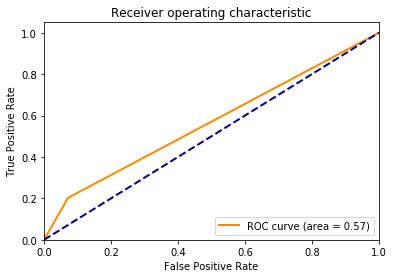

In [141]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

# Binarize the output
Y_zsl_test = label_binarize(Y_zsl, classes=['car', 'food', 'hand', 'man', 'neck'])
final_1_test = label_binarize(final_1, classes=['car', 'food', 'hand', 'man', 'neck'])
n_classes = Y_zsl_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_zsl_test[:, i], final_1_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_zsl_test.ravel(), final_1_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [139]:
Y_zsl_test.shape

(1999, 20)

In [142]:
tpr

{0: array([0.        , 0.00250627, 1.        ]),
 1: array([0., 1.]),
 2: array([0.    , 0.2025, 1.    ]),
 3: array([0.    , 0.2375, 1.    ]),
 4: array([0.   , 0.295, 1.   ]),
 'micro': array([0.        , 0.14757379, 1.        ])}

In [143]:
fpr

{0: array([0.     , 0.00125, 1.     ]),
 1: array([0., 1.]),
 2: array([0.        , 0.07129456, 1.        ]),
 3: array([0.        , 0.00187617, 1.        ]),
 4: array([0.       , 0.0137586, 1.       ]),
 'micro': array([0.        , 0.01763382, 1.        ])}

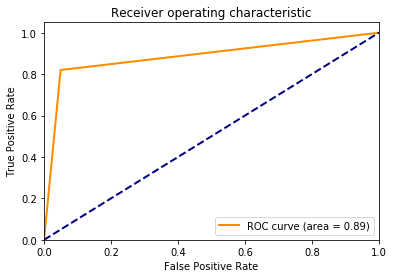

In [151]:
# Binarize the output
Y_zsl_test = label_binarize(Y_zsl, classes=['car', 'food', 'hand', 'man', 'neck'])
final_3_test = label_binarize(final_3, classes=['car', 'food', 'hand', 'man', 'neck'])
n_classes = Y_zsl_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_zsl_test[:, i], final_3_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_zsl_test.ravel(), final_3_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

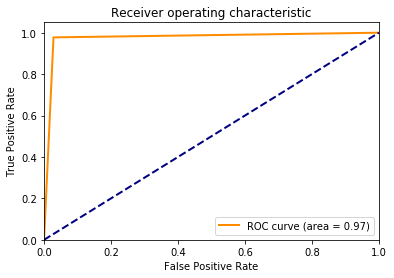

In [150]:
# Binarize the output
Y_zsl_test = label_binarize(Y_zsl, classes=['car', 'food', 'hand', 'man', 'neck'])
final_5_test = label_binarize(final_5, classes=['car', 'food', 'hand', 'man', 'neck'])
n_classes = Y_zsl_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_zsl_test[:, i], final_5_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_zsl_test.ravel(), final_5_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

# Testing on Image

In [54]:
image_path = "index.jpg"

In [55]:
img = Image.open(image_path).resize((224, 224))

## VGG16 for Feature Extraction

In [56]:
vgg_model = keras.applications.VGG16(include_top=True, weights='imagenet')

In [57]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [58]:
vgg_model.layers.pop()
vgg_model.layers.pop()

In [59]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [60]:
input_vgg = vgg_model.input
output_vgg = vgg_model.layers[-1].output
model_vgg = Model(input_vgg, output_vgg)

## Image Preprocessing

In [61]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = keras.applications.vgg16.preprocess_input(x)
features = model_vgg.predict(x)

In [62]:
features

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [63]:
img_feature = normalize(features, norm='l2')

In [64]:
img_feature

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [65]:
pred = zsl_model.predict(img_feature)

In [66]:
pred

array([[0.19039525, 0.0125703 , 0.        , 0.03588982, 0.08426309,
        0.        , 0.7387859 , 0.        , 0.39554322, 0.        ,
        0.        , 0.        , 0.25593883, 0.0199687 , 0.3946091 ,
        0.        , 0.        , 0.        , 0.6670442 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.26093656, 0.5614096 ,
        0.        , 0.        , 0.        , 0.88070315, 0.        ,
        0.08957934, 0.        , 0.2528163 , 0.        , 0.4383249 ,
        0.1783107 , 1.4853987 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.3947936 , 0.        , 0.6840002 ,
        0.00296584, 0.5058446 , 0.        , 0.40731847, 0.        ,
        0.        , 0.        , 1.3288292 , 0.9042173 , 0.03024249,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.39054233, 0.01527675, 0.        , 0.66

In [67]:
tree = KDTree(vectors)

In [68]:
dist, index = tree.query(pred, k=3)
pred_labels = [class_names[idx] for idx in index[0]]

In [69]:
pred_labels

['vehicle', 'truck', 'car']

In [70]:
print("Top-3 Prediction")
for i, classname in enumerate(pred_labels):
    print("%d : - %s" %(i+1, classname))

Top-3 Prediction
1 : - vehicle
2 : - truck
3 : - car
